# UCLQ Quantum Energy Hackathon 
## Working example - February 2022

### [QAOA](https://qiskit.org/textbook/ch-applications/qaoa.html) (Quantum Approximate Optimization Algorithm) is a hearistic method of using quantum computing hardware as it is to find solutions to optimization problems.

### 1. Install quiskit 

In [2]:
# uncomment if qiskit is not installed
# !pip install qiskit

In [4]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize

### 2. Define the parameters of your problem
In this example, we considered the cost and revenue for 3 renewable energy sources and optimised their distribution for 4 locations in the United Kingdom. Data used for this example is contained in _EQ_constants.csv_

For each energy source in each location the following parameters were estimated: 

    1) Revenue: total energy generated by the renewable energy unit
    
    2) Cost: total cost of constructing and mantaining the renewable energy unit
    
    3) Location capacity: the maximum number of units that can be placed in each location, note that a solar unit in this example is a solar pannel and a wind unit is a wind turbine.
    
The total cost is the total energy consumption for the United Kingdom in 2019. NOTE: the units for all the parameters are transformed in sterling pounds £. For full details consult the provided spreadsheet _EQ_constants.csv_


In [134]:
# Renewable sources: solar, on-shore and off-shore wind turbines
number_of_renewable_sources = 4

## ADJUSTED
load_factors = [26.8, 34.375 , 9.5]

# Locations: England, Northern Ireland, Scotland, Wales
number_of_locations = 6

# Calculate the number of qubits needed, 
# NOTE: IBMQ systems accesible have 5 qubits
nqubits = number_of_locations * number_of_renewable_sources

G = nx.complete_graph(nqubits)

## ADJUSTED
total_cost = C = 65723270440 # units: £

energy_price_ratio = 1

# dict{location: [energy_source]}
location_revenue_per_unit = {
    0: [2783.55, 336113.74, 153105454.50, 15586776.5],
    1: [2783.55, 336113.74, 153105454.50, 15586776.5],
    2: [2783.55, 336113.74, 153105454.50, 15586776.5],
    3: [2332.31, 434451.22, 0.0, 56331696],
    4: [1088.38, 1020438.50, 85798571.43, 4857121.5],
    5: [3573.59, 768855.93, 140790000, 3553219.23]
}

# Calculate cost for each energy source in all locations
# dict{location: [energy_source]}
location_cost_per_unit = {
    0: [300.92, 52370.72, 22696783.84, 4263220.1],
    1: [300.92, 52370.72, 22696783.84, 4263220.1],
    2: [300.92, 52370.72, 22696783.84, 4263220.1],
    3: [273.66, 70226.14, 0.0, 1508168.9],
    4: [116.17, 161395.70, 11626961.90, 1296099.8],
    5: [382.92, 122708.47, 21872844.44, 1091226.23]
}

# variable and a rough estimate, see spreadsheet for current figures.
# dict{location: [energy_source]}
location_unit_capacity = {
    0: [264387, 1468, 13, 125],
    1: [216019, 1587, 15, 125],
    2: [262652, 954, 5, 103],
    3: [23869.00, 1312.00, 0.00, 23],
    4: [61449.00, 3512.00, 7.00, 79],
    5: [55773.00, 708.00, 3.00, 52]
}

# Order of regions below: 
# East Midlands
# East
# North East
# North West
# London
# South East
# South West
# West Midlands
# Yorkshire and The Humber
# Northern Ireland
# Scotland (inc unallocated)
# Wales


# ## ADJUSTED
# # Calculate revenue for each energy source in all locations 
# # dict{location: [energy_source]}
# location_revenue_per_unit = {
#     0: [2784.29, 335531.91, 153076666.7],
#     1: [2783.374, 336321.84, 153102000],
#     2: [2782.46, 335781.82, 153076666.7],
#     3: [2784.03, 336296.30, 153097777.8],
#     4: [2782.64, 337096.77, 0],
#     5: [2782.60, 335188.68, 153102000],
#     6: [2784.75, 336046.51, 0],
#     7: [2782.00, 336571.43, 0],
#     8: [2784.28, 336245.31, 153203333.3],
#     9: [2332.31, 434451.22, 0.0],
#     10: [1088.38, 1020438.50, 85798571.43],
#     11: [3573.59, 768855.93, 140790000],
# }

# ## ADJUSTED
# # Calculate cost for each energy source in all locations
# # dict{location: [energy_source]}
# location_cost_per_unit = {
#     0: [300.8894306, 52314.89362, 22688544.44],
#     1: [300.7962805, 52363.33333, 22694586.67],
#     2: [300.8284017, 52404.72727, 22688544.44],
#     3: [300.8260464, 52323.39181, 22688544.44],
#     4: [300.8208336, 52877.41935, 0],
#     5: [300.971306, 52191.50943, 22730840],
#     6: [300.9969135, 52416.27907, 0],
#     7: [300.8538744, 52298.28571, 0],
#     8: [301.109663, 52400.37547, 22688544.44],
#     9: [273.66, 70226.14, 0.0],
#     10: [116.17, 161395.70, 11626961.90],
#     11: [382.92, 122708.47, 21872844.44],
# }

# ## ADJUSTED
# # variable and a rough estimate, see spreadsheet for current figures.
# # dict{location: [energy_source]}
# location_unit_capacity = {
#     0: [87552.00, 423.00, 3.00],
#     1: [105329.00, 870.00, 10.00],
#     2: [47458.00, 275.00, 3.00], 
#     3: [85035.00, 513.00, 9.00],
#     4: [25810.00, 31.00, 0.00],
#     5: [114235.00, 106.00, 5.00],
#     6: [122607.00, 817.00, 0.00],
#     7: [71506.00, 175.00, 0.00],
#     8: [83526.00, 799.00, 3.00],
#     9: [23869.00, 1312.00, 0.00],
#     10: [61449.00, 3512.00, 7.00],
#     11: [55773.00, 708.00, 3.00],
# }

# lambda and gamma, the initial parameter guess for the cost function
lam, gam = 1.0, 1.0

# Calculate the total costs and revenues 
a_revs, b_costs = [], []

for N in range(number_of_locations):
    for R in range(number_of_renewable_sources):
        num_units = location_unit_capacity[N][R]
        a_revs.append(num_units * location_revenue_per_unit[N][R] * energy_price_ratio)
        b_costs.append(num_units * location_cost_per_unit[N][R])

In [109]:
# ## Adding a term to account for the usage of energy in different regions (in the same order) - will impact the cost function
# weights = [0.073357663, 0.092893577, 0.039786709, 0.1078887, 0.269809359, 0.134025854, 0.083396828, 0.084704592, 0.081556551, 0.027184941, 0.087065999, 0.053233908]

## Adding a term to account for the usage of energy in different regions (in the same order) - will impact the cost function
weights = [0.2510, 0.2292, 0.4872, 0.027184941, 0.087065999, 0.053233908]

### 3. Define the cost function

The optimisation problem to solved can be described by:
$$ \min_{x_i \in \{0,1\}} f( X = x_1, \dotsc,x_n) =   \gamma \ f_{\text{cost}} (X) -\lambda   f_{\text{yield}}(X)$$


In cost function specific for our example is defined as:

$$ \min_{X \in \{0,1\}^{N\times R}} f(X = x_{11}, \dotsc,x_{nn}) = \lambda\left(C-   \sum_i^{N}\sum_j^{R} a_{ij} x_{ij}\right)^2 + \gamma  \sum_i^{N}\sum_j^{R} b_{ij} x_{ij}\ ,$$

for more details please consult the pdf document provided.


In [99]:
def cost_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """

    obj = lam * C**2
    for i in G.nodes():
        obj += (lam * a_revs[i]**2 + gam * b_costs[i] - 2*lam*C*a_revs[i]) * int(x[i]) / weights[i//number_of_renewable_sources]

    for i, j in G.edges():
        obj += 2 * lam * a_revs[i] * a_revs[j] * int(x[i]) * int(x[j]) / weights[i//number_of_renewable_sources]
            
    return obj

### 4. Define the expectation function

In [100]:
def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = cost_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


### 5. Define the circuit for QAOA algorithm

The function will bring the different circuit components that build the qaoa circuit under a single function

In [101]:
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary biases
        for i in list(G.nodes()):
            qc.rz(2 * gamma[irep], i)
        # problem unitary couplings
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

### 6. Define function to run the quantum circuit on the backend of choosing (in this example the IBM Air simulator was used)

In [102]:
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

### 7. Optimize the quantum circuit parameters

In [103]:
expectation = get_expectation(G, p=1)

res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

     fun: -1.3491688312515684e+22
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 27
  status: 1
 success: True
       x: array([0.99956368, 1.00388099])

### 8. Run quantum circuit

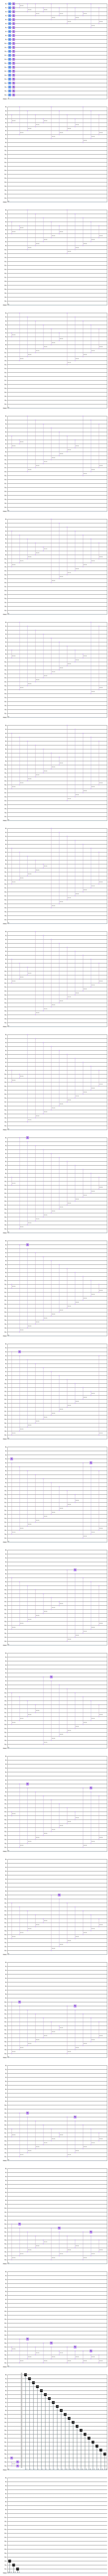

In [104]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)
# Visualise the quantum circuit
qc_res.draw(output='mpl')

### 8. Analyse the resulting distribution

/tmp/ipykernel_13509/2761394752.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xs, fontsize=10, rotation=-45)


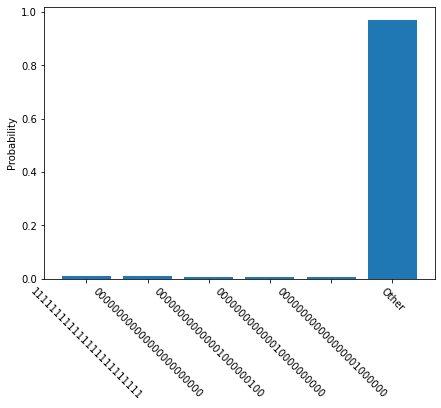

In [105]:
# Obtain simulation results
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
strings = list(counts.keys())
probabilities = np.array([counts[string]/1024 for string in strings])

# Plot the first 5 highest scores (energy sources and corresponding locations)
num_highest = 5
perm = np.flip((np.argsort(probabilities)))
indices = perm[0:num_highest]
xs = [strings[i] for i in indices] + ["Other"]
ys = [probabilities[i] for i in indices] + [sum(probabilities[perm[num_highest:]])]


fig, ax = plt.subplots(1, 1,figsize=(7, 5))
ax.bar(xs, ys)
ax.set_xticklabels(xs, fontsize=10, rotation=-45)
ax.set_ylabel("Probability")
plt.show()

/tmp/ipykernel_13509/3361619287.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xs, fontsize=10, rotation=-45)


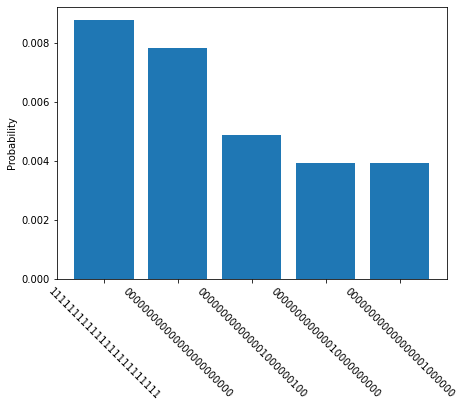

In [106]:
num_highest = 5
perm = np.flip((np.argsort(probabilities)))
indices = perm[0:num_highest]
xs = [strings[i] for i in indices]
ys = [probabilities[i] for i in indices]


fig, ax = plt.subplots(1, 1,figsize=(7, 5))
ax.bar(xs, ys)
ax.set_xticklabels(xs, fontsize=10, rotation=-45)
ax.set_ylabel("Probability")
plt.show()

### Integer Linear Programming Problem to decide the number of units in each region

In [ ]:
# Calculate the total costs and revenues 
a_revs, b_costs = [], []

for N in range(number_of_locations):
    for R in range(number_of_renewable_sources):
        num_units = location_unit_capacity[N][R]
        a_revs.append(num_units * location_revenue_per_unit[N][R] * energy_price_ratio)
        b_costs.append(num_units * location_cost_per_unit[N][R])



In [137]:
b_costs_ = [element*-1 for element in b_costs]
# print(b_costs_)

c = a_revs + b_costs_
print(len(c))

48


In [152]:
# Import packages
from pulp import LpMaximize, LpProblem, LpStatus, LpVariable

model = LpProblem(name="units", sense=LpMaximize)

# Initialize the decision variables
# Middle England
x_1 = LpVariable(name="x_1", lowBound=1, upBound=264387, cat="Integer")
x_2 = LpVariable(name="x_2", lowBound=1, upBound=1468, cat="Integer")
x_3 = LpVariable(name="x_3", lowBound=1, upBound=13, cat="Integer")
x_4 = LpVariable(name="x_4", lowBound=1, upBound=125, cat="Integer")

# North England
x_5 = LpVariable(name="x_5", lowBound=1, upBound=216019, cat="Integer")
x_6 = LpVariable(name="x_6", lowBound=1, upBound=1587, cat="Integer")
x_7 = LpVariable(name="x_7", lowBound=1, upBound=15, cat="Integer")
x_8 = LpVariable(name="x_8", lowBound=1, upBound=125, cat="Integer")

# South England
x_9 = LpVariable(name="x_9", lowBound=1, upBound=262652, cat="Integer")
x_10 = LpVariable(name="x_10", lowBound=1, upBound=954, cat="Integer")
x_11 = LpVariable(name="x_11", lowBound=1, upBound=5, cat="Integer")
x_12 = LpVariable(name="x_12", lowBound=1, upBound=103, cat="Integer")

# Northern Ireland
x_13 = LpVariable(name="x_13", lowBound=1, upBound=23869, cat="Integer")
x_14 = LpVariable(name="x_14", lowBound=1, upBound=1312, cat="Integer")
x_15 = LpVariable(name="x_15", lowBound=1, upBound=1, cat="Integer")
x_16 = LpVariable(name="x_16", lowBound=1, upBound=23, cat="Integer")

# Scotland
x_17 = LpVariable(name="x_17", lowBound=1, upBound=61449, cat="Integer")
x_18 = LpVariable(name="x_18", lowBound=1, upBound=3512, cat="Integer")
x_19 = LpVariable(name="x_19", lowBound=1, upBound=7, cat="Integer")
x_20 = LpVariable(name="x_20", lowBound=1, upBound=79, cat="Integer")

# Wales
x_21 = LpVariable(name="x_21", lowBound=1, upBound=55773, cat="Integer")
x_22 = LpVariable(name="x_22", lowBound=1, upBound=708, cat="Integer")
x_23 = LpVariable(name="x_23", lowBound=1, upBound=3, cat="Integer")
x_24 = LpVariable(name="x_24", lowBound=1, upBound=52, cat="Integer")


runit = location_revenue_per_unit
cunit = location_cost_per_unit

# Set up the constraints
obj_fun = (weights[0]*(x_1 * runit[0][0] + x_2 * runit[0][1] + x_3 * runit[0][2] + x_4 * runit[0][3] - (x_1 * cunit[0][0] + x_2 * cunit[0][1] + x_3 * cunit[0][2] + x_4 * cunit[0][3])) + 
           weights[1]*(x_5 * runit[1][0] + x_6 * runit[1][1] + x_7 * runit[1][2] + x_8 * runit[1][3] - (x_5 * cunit[1][0] + x_6 * cunit[1][1] + x_7 * cunit[1][2] + x_8 * cunit[1][3])) + \
           weights[2]*(x_9 * runit[2][0]  + x_10 * runit[2][1] + x_11 * runit[2][2] + x_12 * runit[2][3] - (x_9 * cunit[2][0] + x_10 * cunit[2][1] + x_11 * cunit[2][2] + x_12 * cunit[2][3])) + \
           weights[3]*(x_13 * runit[3][0] + x_14 * runit[3][1] + x_14 * runit[3][2] + x_15 * runit[3][3] - (x_13 * cunit[3][0] + x_14 * cunit[3][1] + x_15 * cunit[3][2] + x_16 * cunit[3][3])) + \
           weights[4]*(x_17 * runit[4][0] + x_18 * runit[4][1] + x_19 * runit[4][2] + x_20 * runit[4][3] - (x_17 * cunit[4][0] + x_18 * cunit[4][1] + x_19 * cunit[4][2] + x_20 * cunit[4][3])) + \
           weights[5]*(x_21 * runit[5][0] + x_22 * runit[5][1] + x_23 * runit[5][2] + x_24 * runit[5][3] - (x_21 * cunit[5][0] + x_22 * cunit[5][1] + x_23 * cunit[5][2] + x_24 * cunit[5][3])))

# Add the objective function to the model
model += obj_fun
model

status = model.solve()

# Evaluate the cost function
# print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")

# Display solution
for var in model.variables():
    print(f"{var.name}: {var.value()}")

for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/shreevanth/Desktop/ucl-hack/.venv/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/b4f26209eced4ce892df81063275d6ec-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/b4f26209eced4ce892df81063275d6ec-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 78 RHS
At line 79 BOUNDS
At line 127 ENDATA
Problem MODEL has 0 rows, 24 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3.79749e+09 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -3.79749e+09 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)